In [1]:
# Import lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as image
import glob
import os



In [2]:
images_fp = './images'

In [3]:
image_names = [os.path.basename(file) for file in glob.glob(os.path.join(images_fp,'*.jpg'))]

In [4]:
len(image_names)

7390

In [5]:
labels = [' '.join(names.split('_')[:-1:]) for names in image_names]

In [25]:
len(labels)

3000

In [ ]:
def label_encode(label):
    if label == 'Abyssinian': return 0
    elif label == 'Bengal': return 1
    elif label == 'Birman': return 2
    elif label == 'Bombay': return 3
    elif label == 'British Shorthair': return 4
    elif label == 'Egyptian Mau': return 5
    elif label == 'american bulldog': return 6
    elif label == 'american pit bull terrier': return 7
    elif label == 'basset hound': return 8
    elif label == 'beagle': return 9
    elif label == 'boxer': return 10
    elif label == 'chihuahua': return 11
    elif label == 'english cocker spaniel': return 12
    elif label == 'english setter': return 13
    elif label == 'german shorthaired': return 14    
    elif label == 'great pyrenees': return 15    
           

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [43]:
features = []
labels = []
IMAGE_SIZE = (224,224)

for name in image_names: 
    label = ' '.join(name.split('_')[:-1:])
    label_encoded = label_encode(label)
    if label_encoded != None:
         img = load_img(os.path.join(images_fp, name))
         img = img_to_array(img, dtype='float32')  # Use float32 for compatibility with preprocessing
         img = tf.image.resize_with_pad(img, *IMAGE_SIZE).numpy().astype('uint8')
         image = np.array(img)
         features.append(image)
         labels.append(label_encoded)          

In [44]:
len(features)

3000

In [45]:
len(labels)

3000

In [46]:
features_array = np.array(features)
labels_array = np.array(labels)

In [47]:
labels_one_hot = pd.get_dummies(labels_array, dtype = int)
labels_one_hot

,0,1,2,3,5,6,7,8,9,10,11,12,13,14,15
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [48]:
from sklearn.model_selection import train_test_split

In [49]:
# Train - 60% + val = 20% and Test: 20%
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_one_hot, test_size = 0.2, random_state = 42)

In [50]:
# 80%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)


In [51]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as pp_i
from tensorflow.keras.layers import RandomFlip, RandomRotation, Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


In [57]:
data_augmentation = Sequential([RandomFlip("horizontal_and_vertical"), RandomRotation(0.2)])
prediction_layers = Dense(15, activation = 'softmax')


In [58]:
resnet_model = ResNet50(include_top=False, pooling='avg', weights='imagenet')
resnet_model.trainable = False
preprocess_input = pp_i


In [59]:
#Build model
inputs = Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = resnet_model(x, training=False)
x = Dropout(0.2)(x)
outputs = prediction_layers(x)
model = Model(inputs, outputs)

In [60]:
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics = ['accuracy'])

In [61]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 224, 224,  │          0 │ input_layer_10[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_4 (Stack)     │ (None, 224, 224,  │          0 │ get_item_12[0][0… │
│                     │ 3)                │            │ get_item_13[0][0… │
│                     │                   │            │ get_item_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 224, 224,  │          0 │ stack_4[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ add_4[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2048)      │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 15)        │     30,735 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,618,447 (90.10 MB)

 Trainable params: 30,735 (120.06 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [62]:
model_history = model.fit(x=X_train, y=y_train,  validation_data=(X_val, y_val), epochs=10)


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.3097 - loss: 2.3944 - val_accuracy: 0.7867 - val_loss: 0.6091
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.7574 - loss: 0.7996 - val_accuracy: 0.8917 - val_loss: 0.3820
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7927 - loss: 0.5975 - val_accuracy: 0.9117 - val_loss: 0.3003
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.8250 - loss: 0.5132 - val_accuracy: 0.8883 - val_loss: 0.3170
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8411 - loss: 0.4808 - val_accuracy: 0.9067 - val_loss: 0.2770
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8686 - loss: 0.4258 - val_accuracy: 0.9267 - val_loss: 0.2510
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.8809 - loss: 0.3663 - val_accuracy: 0.9150 - val_loss: 0.2500
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8667 - loss: 0.3881 - val_accuracy: 0.9217 - v

In [63]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

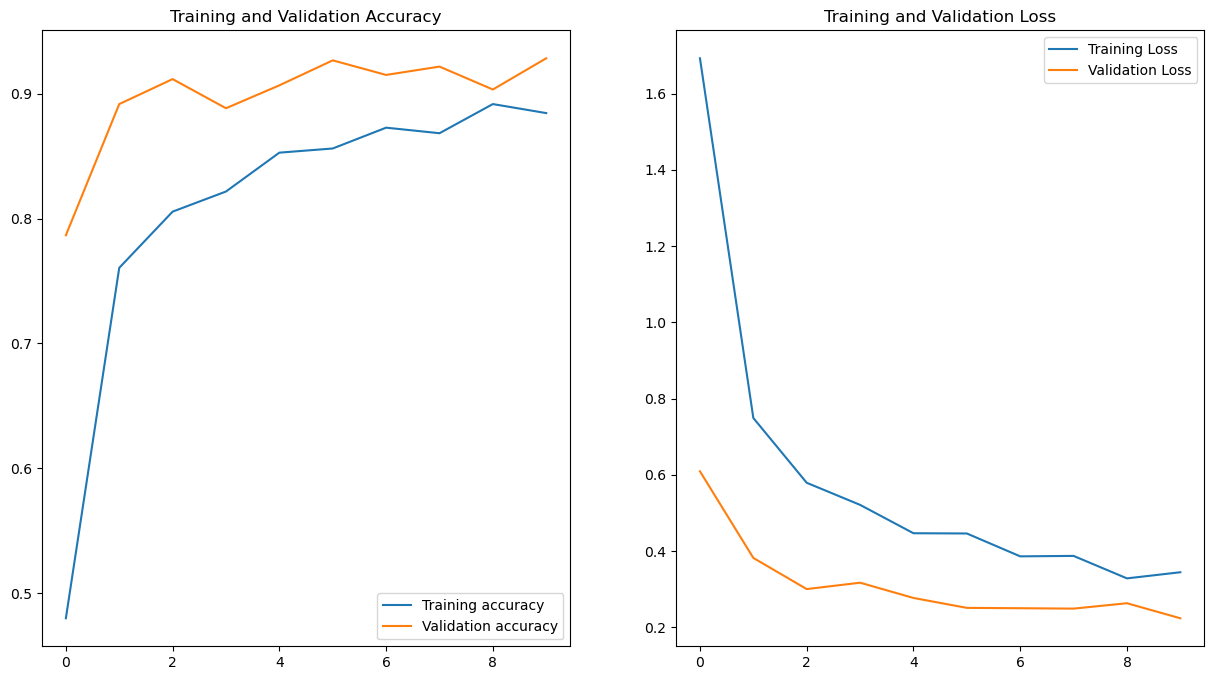

In [64]:
epochs_range = range(10)
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(epochs_range,acc, label='Training accuracy')
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs_range,val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(epochs_range,loss, label='Training Loss')
plt.plot(epochs_range,val_loss, label='Validation Loss')
plt.legend(loc= 'upper right')
plt.title('Training and Validation Loss')

In [65]:
model.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9075 - loss: 0.2398


[0.21088388562202454, 0.92166668176651]

In [66]:
y_pred = model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step


In [67]:
y_pred

array([[4.4473814e-04, 2.3059128e-04, 6.3869409e-04, ..., 6.9487119e-06,
        2.5590984e-04, 1.0281329e-05],
       [4.9069250e-04, 9.9650502e-01, 2.6417861e-06, ..., 2.1322616e-05,
        2.0817242e-05, 1.2869600e-06],
       [6.7073539e-05, 1.4223922e-03, 4.4088783e-03, ..., 1.5116702e-03,
        1.0230151e-03, 7.8560464e-05],
       ...,
       [1.3094678e-03, 3.4385786e-04, 2.3109940e-05, ..., 2.5866237e-05,
        5.9946802e-02, 2.2041704e-06],
       [5.1328436e-07, 1.2325977e-06, 8.9642818e-08, ..., 1.0733072e-08,
        1.7527776e-05, 2.0773736e-09],
       [3.3071762e-04, 3.5113742e-04, 9.6898770e-01, ..., 2.6189711e-05,
        1.8490516e-06, 2.9871944e-02]], dtype=float32)